In [ ]:
from dataset import YouCookII
from dataset import YouCookIICollate
from torch.utils.data import DataLoader
from loss import loss_RA_MIL
from transformers import get_linear_schedule_with_warmup
from model import Model
from model_FC import ModelFC

import numpy as np
import torch
import matplotlib.pyplot as plt

import itertools
import torch
import einops
import torch.nn.functional as F

from transformers import LxmertModel, LxmertTokenizer
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from loss import loss_RA_MIL

from model import *

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
ACTION = '[unused3]'

lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")
lxmert_tokenizer.add_special_tokens({"additional_special_tokens": [ACTION]})
lxmert_tokenizer.encode([ACTION])

lxmert = LxmertModel.from_pretrained("unc-nlp/lxmert-base-uncased")
lxmert.to(device)

ACTION_TOKEN = lxmert_tokenizer.convert_tokens_to_ids(ACTION)

In [ ]:
num_actions = 8
MAX_DETECTIONS=20
batch_size = 1

DETECTION_EMBEDDING_SIZE = 2048
OUTPUT_EMBEDDING_SIZE = 768
NUM_FRAMES_PER_STEP=5
MAX_DETECTIONS=20
CANDIDATES = NUM_FRAMES_PER_STEP * MAX_DETECTIONS

dataset = YouCookII(num_actions, "/h/sagar/ece496-capstone/datasets/ycii")
collate = YouCookIICollate(MAX_DETECTIONS=MAX_DETECTIONS)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)

In [ ]:
model = Model(device, MAX_DETECTIONS=20)

In [ ]:
_, boxes, features, steps_list, entity_list, entity_count_list, _, _ = next(iter(dataloader))

In [ ]:
steps_list = remove_unused2(steps_list)

In [ ]:
entities_count = entity_count_list[0]
entities = entity_list[0]
steps = steps_list[0]

In [ ]:
steps = [step.strip() for step in steps.split(ACTION)[:-2]]

In [ ]:
boxes = boxes.squeeze(0)
boxes = boxes.reshape(num_actions, CANDIDATES, -1)
boxes = boxes.to(device)

features = features.squeeze(0)
features = features.reshape(num_actions, CANDIDATES, -1)
features = features.to(device)

In [ ]:
boxes.shape

In [ ]:
from random import choice
from random import seed

seed(0)

steps_pairs = []
bboxes_pairs = torch.zeros(num_actions, 2, CANDIDATES, 4)
features_pairs = torch.zeros(num_actions, 2, CANDIDATES, DETECTION_EMBEDDING_SIZE)
entity_list_pairs = []
num_steps = len(steps)
pairs = []

for idx, step in enumerate(steps):
    idx_1 = idx
    idx_2 = choice([idx_2 for idx_2 in range(num_steps) if idx_2 != idx_1])
    
    pairs.append((idx_1, idx_2))
    
    steps_pairs.append(steps[idx_1] + " " + ACTION + " " + steps[idx_2] + " " + ACTION + " " + ACTION)
    
    bboxes_pairs[idx_1][0] = boxes[idx_1]
    bboxes_pairs[idx_1][1] = boxes[idx_2]
    
    features_pairs[idx_1][0] = features[idx_1]
    features_pairs[idx_1][1] = features[idx_2]
    
    entity_list_pairs.append([entities[idx_1], entities[idx_2]])
    
bboxes_pairs = bboxes_pairs.reshape(num_actions, 2 * CANDIDATES, -1)
bboxes_pairs = bboxes_pairs.to(device)

features_pairs = features_pairs.reshape(num_actions, 2 * CANDIDATES, DETECTION_EMBEDDING_SIZE)
features_pairs = features_pairs.to(device)

entity_count = [len(action) for action in sum(entity_list_pairs, [])]

In [ ]:
entity_list_pairs


In [ ]:
#2*num_actions - entities in action 1 (pair 1), action 2 (pair 1), action 1 (pair 2) action 2 (pair 2) etc.
entity_count

In [ ]:
boxes.shape

In [ ]:
pairs

In [ ]:
steps_pairs

In [ ]:
entity_list_pairs

In [ ]:
print(bboxes_pairs.shape)
print(features_pairs.shape)

In [ ]:
inputs = lxmert_tokenizer(
            steps_pairs,
            padding="longest",
            truncation=False,
            return_token_type_ids=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

inputs.input_ids = inputs.input_ids.to(device)
inputs.attention_mask = inputs.attention_mask.to(device)
inputs.token_type_ids = inputs.token_type_ids.to(device)

output = lxmert(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            visual_feats=features_pairs,
            visual_pos=bboxes_pairs,
            token_type_ids=inputs.token_type_ids,
            return_dict=True,
            output_attentions=True
        )

In [ ]:
entity_idx

In [ ]:
action_idx

In [ ]:
entity_list_pairs

In [ ]:
entity_idx

In [ ]:
entity_count

In [ ]:
entity_idx = get_ent_inds(model, entity_list_pairs, steps_pairs)
entity_embeddings = get_entity_embeddings(output['language_output'], entity_idx).split(entity_count)

action_idx = (inputs.input_ids == ACTION_TOKEN)
A = output['language_output'][action_idx]

V = output['vision_output']

In [ ]:
entity_count

In [ ]:
#entity_embeddings is 16 (tuple) x entity_count x 768
entity_embeddings[4].size()

In [ ]:
len(entity_embeddings)

In [ ]:
#gather entity embeddings in each pair together
E = []

for i in range(num_actions):
    idx_1 = 2 * i
    idx_2 = idx_1 + 1
    E.append([entity_embeddings[idx_1], entity_embeddings[idx_2]])

In [ ]:
#embedding of entity 1 in action 1 of pair 1
len(E[0][0][1])

In [ ]:
#entity embeddings in action step i, pair 1
E[2][0].size()

In [ ]:
#the visual embeddings in action step i (200 - for both pairs)
V[0].size()

In [ ]:
(E[0][0][0]*V[0][:100]).sum(dim=-1)

In [ ]:
VG = []

for i in range(num_actions):    
    pair_1 = []
    pair_2 = []
    
    #iterate through all entities in pair 1 of this action step
    #computing score with 
    for ent_1 in E[i][0]:
        #100 large score (for each bbox with this entity)
        alignment_scores = (ent_1 * V[i][0:100]).sum(dim=-1)
        pair_1.append(int(alignment_scores.argmax()))
                
    for ent_2 in E[i][1]:
        alignment_scores = (ent_2 * V[i][100:]).sum(dim=-1)
        pair_2.append(int(alignment_scores.argmax()))
        
    VG.append([pair_1, pair_2])

In [ ]:
VG

In [ ]:
#seems to be num_actions x num_pairs (2) x num_entities in pair x 768
len(VG_V[0][0][0])

In [ ]:
VG_V = []

for i, pair in enumerate(VG):
    VG_V.append([])
    for j, action in enumerate(pair):
        VG_V[i].append([])
        for k, entity in enumerate(action):
            if j == 0:
                VG_V[i][j].append(V[i][0:100][VG[i][j][k]])
            else:
                VG_V[i][j].append(V[i][100:][VG[i][j][k]])

In [ ]:
VG

In [ ]:
from dataset import YouCookII
from dataset import YouCookIICollate
from torch.utils.data import DataLoader
from loss import loss_RA_MIL
from transformers import get_linear_schedule_with_warmup
from model import Model
from model_FC import ModelFC

import numpy as np
import torch
import matplotlib.pyplot as plt

def train(model, num_actions, batch_size, epochs=25, lr=0.001, y=0.5, MAX_DETECTIONS=20):
    dataset = YouCookII(num_actions, "/h/sagar/ece496-capstone/datasets/ycii")
    train_size = int(len(dataset) * (2/3))
    valid_size = int(len(dataset) - train_size)
    
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
    
    collate = YouCookIICollate(MAX_DETECTIONS=MAX_DETECTIONS)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.2*epochs), epochs)

    train_loss = np.zeros(epochs)
    valid_loss = np.zeros(epochs)
    
    model.train()
    
    batch = 4
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0
        loss_ = 0
        for idx, data in enumerate(train_dataloader):
            _, bboxes_tensor, features_tensor, steps_list, entity_list, entity_count_list, _, _ = data
            batch_size = len(data[0])
            
            # Zero out any gradients.
            optimizer.zero_grad()
            
            # Run inference (forward pass).
            E, V, outputs, inputs = model(batch_size, num_actions + 1, steps_list, features_tensor, bboxes_tensor, entity_count_list, entity_list)            
            
            # Loss from alignment.
            loss_ = get_loss(E, V)

            # Backpropagation (backward pass).
            loss_.backward()

            # Update parameters.
            optimizer.step()
            
            epoch_loss += loss_
            num_batches += 1
        
        # learning rate schedule
        # update after each epoch
        scheduler.step()
        epoch_loss = epoch_loss / num_batches
        
        # Save loss and accuracy at each epoch, plot (and checkpoint).
        train_loss[epoch] = epoch_loss
        valid_loss[epoch] = get_validation_loss(model, num_actions, y, valid_dataloader)
        
        # after epoch completes
        print("Epoch {} - Train Loss: {}, Validation Loss: {}".format(epoch + 1, train_loss[epoch], valid_loss[epoch]))
    
    plt.plot(train_loss, label='train loss')
    plt.plot(valid_loss, label='valid loss')
    plt.legend()
    plt.show()
        
    return train_loss, valid_loss

def get_validation_loss(model, num_actions, y, valid_dataloader):
    epoch_loss = 0.0
    num_batches = 0
        
    with torch.no_grad():
        for data in valid_dataloader:
            _, bboxes_tensor, features_tensor, steps_list, entity_list, entity_count_list, _, _ = data
            batch_size = len(data[0])

            # Run inference (forward pass).
            E, V, outputs, inputs = model(batch_size, num_actions + 1, steps_list, features_tensor, bboxes_tensor, entity_count_list, entity_list)

            # Loss from alignment.
            loss_ = get_loss(E, V)
            
            epoch_loss += loss_
            num_batches += 1
            
    epoch_loss = epoch_loss / num_batches
    
    return epoch_loss

# Training

In [1]:
def get_loss(E, V):
    loss = 0

    for entity, box in zip(E, V):
        loss = loss + loss_pair(entity, box)
        
    print(int(loss))
        
    return loss

#E and V are of shape 2 x num-entities x 768
def loss_pair(E, V):
    delta = torch.full((1, 1), 1000.0).to(device)
    
    loss = 0

    #assert(len(V) == len(E))

    num_actions = len(E)
    
    zero = torch.zeros((1)).to(device)

    for l in range(num_actions):
        for m in range(num_actions):
            before_delta = S_lm(l, m, E, V) - S_lm(l, l, E, V)
            loss = loss + torch.max(zero, (before_delta + delta))[0]

        for m in range(num_actions):
            before_delta = S_lm(m, l, E, V) - S_lm(l, l, E, V)
            loss = loss + torch.max(zero, (before_delta + delta))[0]
            
    #print("Loss: {}".format(loss))
            
    return loss

#INPUTS are ENTITIES and V for each action step
def S_lm(l, m, E, V):
    #print("Computing S_{}{}".format(l, m))
    
    entities = E[m]
    scores = 0
    
    #boxes_l_pair = torch.stack([V[:100, :], V[100:,:]])
    
    #pick pair 1 or 0 from l specified
    if l == 0:
        boxes_l = V[:100, :]
    else:
        boxes_l = V[100:, :]
        
    #if (len(VG_V[l]) == 0):
    #    return 0
    
    #boxes = torch.stack(VG_V[l])
    #print(boxes.size())
    for j, ent in enumerate(entities):
        #boxes_l should be 100 x 768
            #print(boxes_l.size())
            #broadcasting to get dot prouct with all bboxes in step l (pair part)
            #l = 0 or 1
            ent = ent.to(device)
            max_score = (ent*boxes_l).sum(dim=-1).max()
            scores += max_score
            #scores = scores + (ent * boxes_l).sum(dim=-1).max()
        
    return scores

In [2]:
from dataset import YouCookII
from dataset import YouCookIICollate
from torch.utils.data import DataLoader
from loss import loss_RA_MIL
from transformers import get_linear_schedule_with_warmup
from model import Model
from model_FC import ModelFC

import numpy as np
import torch
import matplotlib.pyplot as plt

def train(model, num_actions, batch_size, epochs=25, lr=0.001, y=0.5, MAX_DETECTIONS=20):
    #dataset = YouCookII(num_actions, "/h/sagar/ece496-capstone/datasets/ycii")
    #train_size = int(len(dataset) * (2/3))
    #valid_size = int(len(dataset) - train_size)
    
    #train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
    
    collate = YouCookIICollate(MAX_DETECTIONS=MAX_DETECTIONS)
    
    #train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)
    #valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.2*epochs), epochs)

    train_loss = np.zeros(epochs)
    valid_loss = np.zeros(epochs)
        
    for epoch in range(epochs):
        model.train()
        
        epoch_loss = 0.0
        num_batches = 0
        loss_ = 0
        
        #_, bboxes_tensor, features_tensor, steps_list, entity_list, entity_count_list, _, _ = data
        batch_size = 1

        # Zero out any gradients.
        optimizer.zero_grad()

        # Run inference (forward pass).
        E, V, outputs, inputs, VG_ind = model(batch_size, num_actions + 1, steps_list_, features_, bboxes_, entity_count_list_, entity_list_)            

        # Loss from alignment.
        loss_ = get_loss(E, V)

        # Backpropagation (backward pass).
        loss_.backward()

        # Update parameters.
        optimizer.step()

        epoch_loss += loss_
        num_batches += 1
        
        # learning rate schedule
        # update after each epoch
        scheduler.step()
        epoch_loss = epoch_loss / num_batches
        
        # Save loss and accuracy at each epoch, plot (and checkpoint).
        train_loss[epoch] = epoch_loss
        valid_loss[epoch] = -1#get_validation_loss(model, num_actions, y, valid_dataloader)
        
        with torch.no_grad():
            correct = 0
            incorrect = 0
            
            model.eval()
            for i in range(2):    
                for ent_1 in E[i][0]:
                    aligned = (ent_1 * V[i][0:100]).sum(dim=-1)
                    aligned = aligned.argmax()

                    unaligned = (ent_1 * V[i][100:]).sum(dim=-1)
                    unaligned = unaligned.argmax()

                    print("Aligned: {}, Unaligned: {}".format(aligned, unaligned))

                    if (aligned > unaligned):
                        correct+=1
                    else:
                        incorrect+=1

                for ent_2 in E[i][1]:
                    aligned = (ent_2 * V[i][100:]).sum(dim=-1)
                    aligned = aligned.argmax()

                    unaligned = (ent_2 * V[i][0:100]).sum(dim=-1)
                    unaligned = unaligned.argmax()

                    print("Aligned: {}, Unaligned: {}".format(aligned, unaligned))

                    if (aligned > unaligned):
                        correct+=1
                    else:
                        incorrect+=1

            print("Accuracy: {}".format(correct / (correct + incorrect)))
        
        # after epoch completes
        print("Epoch {} - Train Loss: {}, Validation Loss: {}".format(epoch + 1, train_loss[epoch], valid_loss[epoch]))
    
    plt.plot(train_loss, label='train loss')
    plt.plot(valid_loss, label='valid loss')
    plt.legend()
    plt.show()
        
    return train_loss, valid_loss

def get_validation_loss(model, num_actions, y, valid_dataloader):
    epoch_loss = 0.0
    num_batches = 0
        
    with torch.no_grad():
        for data in valid_dataloader:
            _, bboxes_tensor, features_tensor, steps_list, entity_list, entity_count_list, _, _ = data
            batch_size = len(data[0])

            # Run inference (forward pass).
            E, V, outputs, inputs = model(batch_size, num_actions + 1, steps_list, features_tensor, bboxes_tensor, entity_count_list, entity_list)

            # Loss from alignment.
            loss_ = get_loss(E, V)
            
            epoch_loss += loss_
            num_batches += 1
            
    epoch_loss = epoch_loss / num_batches
    
    return epoch_loss

In [3]:
import itertools
import torch
import einops
import torch.nn.functional as F

from transformers import LxmertModel, LxmertTokenizer
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from loss import loss_RA_MIL

from model import *

from random import choice
from random import seed

class ModelTesting(nn.Module):
    ACTION = '[unused3]'

    DETECTION_EMBEDDING_SIZE = 2048
    OUTPUT_EMBEDDING_SIZE = 768

    def __init__(self, device, NUM_FRAMES_PER_STEP=5, MAX_DETECTIONS=20):
        super(ModelTesting, self).__init__()

        self.device = device

        self.NUM_FRAMES_PER_STEP = NUM_FRAMES_PER_STEP
        self.MAX_DETECTIONS = MAX_DETECTIONS
        self.CANDIDATES = self.NUM_FRAMES_PER_STEP * self.MAX_DETECTIONS

        self.lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")
        self.lxmert_tokenizer.add_special_tokens({"additional_special_tokens": [self.ACTION]})
        self.lxmert_tokenizer.encode([self.ACTION])

        self.ACTION_TOKEN = self.lxmert_tokenizer.convert_tokens_to_ids(self.ACTION)

        self.lxmert = LxmertModel.from_pretrained("unc-nlp/lxmert-base-uncased")
        self.lxmert.to(device)

    def forward(self, BATCH_SIZE, NUM_ACTIONS, steps_list, features, boxes, entity_count_list, entity_list):
        assert(BATCH_SIZE == 1)
        
        NUM_ACTIONS = NUM_ACTIONS - 1
        
        steps_list = remove_unused2(steps_list)
        
        entities_count = entity_count_list[0]
        entities = entity_list[0]
        steps = steps_list[0]
        steps = [step.strip() for step in steps.split(self.ACTION)[:-2]]
        
        boxes = boxes.squeeze(0)
        boxes = boxes.to(self.device)
        boxes = boxes.reshape(NUM_ACTIONS, self.CANDIDATES, -1)
        
        features = features.squeeze(0)
        features = features.to(self.device)
        features = features.reshape(NUM_ACTIONS, self.CANDIDATES, -1)

        steps_pairs = []
        
        bboxes_pairs = torch.zeros(NUM_ACTIONS, 2, self.CANDIDATES, 4)
        bboxes_pairs = bboxes_pairs.to(self.device)
        
        features_pairs = torch.zeros(NUM_ACTIONS, 2, self.CANDIDATES, self.DETECTION_EMBEDDING_SIZE)
        features_pairs = features_pairs.to(self.device)
        
        entity_list_pairs = []
        num_steps = len(steps)
        pairs = []
                
        for idx, step in enumerate(steps):
            idx_1 = idx
            idx_2 = choice([idx_2 for idx_2 in range(num_steps) if idx_2 != idx_1])

            pairs.append((idx_1, idx_2))

            steps_pairs.append(steps[idx_1] + " " + self.ACTION + " " + steps[idx_2] + " " + self.ACTION + " " + self.ACTION)

            bboxes_pairs[idx_1][0] = boxes[idx_1]
            bboxes_pairs[idx_1][1] = boxes[idx_2]

            features_pairs[idx_1][0] = features[idx_1]
            features_pairs[idx_1][1] = features[idx_2]

            entity_list_pairs.append([entities[idx_1], entities[idx_2]])
        #print(entity_list_pairs)    
        
        bboxes_pairs = bboxes_pairs.reshape(NUM_ACTIONS, 2 * self.CANDIDATES, -1)
        bboxes_pairs = bboxes_pairs.to(self.device)

        features_pairs = features_pairs.reshape(NUM_ACTIONS, 2 * self.CANDIDATES, self.DETECTION_EMBEDDING_SIZE)
        features_pairs = features_pairs.to(self.device)

        entity_count = [len(action) for action in sum(entity_list_pairs, [])]
        
        inputs = self.lxmert_tokenizer(
            steps_pairs,
            padding="longest",
            truncation=False,
            return_token_type_ids=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        inputs.input_ids = inputs.input_ids.to(self.device)
        inputs.attention_mask = inputs.attention_mask.to(self.device)
        inputs.token_type_ids = inputs.token_type_ids.to(self.device)

        output = self.lxmert(
                    input_ids=inputs.input_ids,
                    attention_mask=inputs.attention_mask,
                    visual_feats=features_pairs,
                    visual_pos=bboxes_pairs,
                    token_type_ids=inputs.token_type_ids,
                    return_dict=True,
                    output_attentions=True
                )
        
        entity_idx = get_ent_inds(self, entity_list_pairs, steps_pairs)
        entity_embeddings = get_entity_embeddings(output['language_output'], entity_idx).split(entity_count)

        action_idx = (inputs.input_ids == self.ACTION_TOKEN)
        A = output['language_output'][action_idx]

        V = output['vision_output']
        
        E = []
        for i in range(NUM_ACTIONS):
            idx_1 = 2 * i
            idx_2 = idx_1 + 1
            E.append([entity_embeddings[idx_1], entity_embeddings[idx_2]])
        
        VG = []
        
        for i in range(NUM_ACTIONS):    
            pair_1 = []
            pair_2 = []

            for ent_1 in E[i][0]:
                alignment_scores = (ent_1 * V[i][0:100]).sum(dim=-1)
                pair_1.append(alignment_scores.argmax())

            for ent_2 in E[i][1]:
                alignment_scores = (ent_2 * V[i][100:]).sum(dim=-1)
                pair_2.append(alignment_scores.argmax())

            VG.append([pair_1, pair_2])
            
        VG_V = []

        for i, pair in enumerate(VG):
            VG_V.append([])
            for j, action in enumerate(pair):
                VG_V[i].append([])
                for k, entity in enumerate(action):
                    if j == 0:
                        VG_V[i][j].append(V[i][0:100][VG[i][j][k]])
                    else:
                        VG_V[i][j].append(V[i][100:][VG[i][j][k]])
                        
        VG_ind = torch.zeros((1, NUM_ACTIONS, max(entity_count))).to(self.device)

        for i, pair in enumerate(VG):
            for k, entity in enumerate(pair[0]):
                VG_ind[0][i][k] = VG[i][0][k]
                        
        #return None, None, None, NUM_ACTIONS, None, None, VG_ind, None
        return E, V, output, inputs, VG_ind

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_test = ModelTesting(device)

15984
Aligned: 35, Unaligned: 66
Aligned: 59, Unaligned: 66
Aligned: 74, Unaligned: 35
Aligned: 36, Unaligned: 95
Aligned: 60, Unaligned: 18
Aligned: 60, Unaligned: 3
Aligned: 69, Unaligned: 84
Aligned: 21, Unaligned: 32
Accuracy: 0.375
Epoch 1 - Train Loss: 15984.544921875, Validation Loss: -1.0
15988
Aligned: 20, Unaligned: 93
Aligned: 23, Unaligned: 93
Aligned: 74, Unaligned: 23
Aligned: 84, Unaligned: 65
Aligned: 74, Unaligned: 18
Aligned: 74, Unaligned: 29
Aligned: 15, Unaligned: 74
Aligned: 29, Unaligned: 74
Accuracy: 0.5
Epoch 2 - Train Loss: 15988.98828125, Validation Loss: -1.0
15983
Aligned: 26, Unaligned: 32
Aligned: 4, Unaligned: 60
Aligned: 32, Unaligned: 26
Aligned: 18, Unaligned: 37
Aligned: 72, Unaligned: 53
Aligned: 81, Unaligned: 31
Aligned: 61, Unaligned: 72
Aligned: 53, Unaligned: 72
Accuracy: 0.375
Epoch 3 - Train Loss: 15983.841796875, Validation Loss: -1.0
15975
Aligned: 95, Unaligned: 95
Aligned: 24, Unaligned: 74
Aligned: 74, Unaligned: 95
Aligned: 74, Unaligne

10870
Aligned: 4, Unaligned: 79
Aligned: 4, Unaligned: 81
Aligned: 76, Unaligned: 98
Aligned: 79, Unaligned: 55
Aligned: 68, Unaligned: 86
Aligned: 71, Unaligned: 39
Aligned: 49, Unaligned: 82
Aligned: 2, Unaligned: 82
Accuracy: 0.25
Epoch 29 - Train Loss: 10870.548828125, Validation Loss: -1.0
9954
Aligned: 3, Unaligned: 70
Aligned: 3, Unaligned: 70
Aligned: 90, Unaligned: 33
Aligned: 85, Unaligned: 33
Aligned: 66, Unaligned: 29
Aligned: 93, Unaligned: 29
Aligned: 16, Unaligned: 7
Aligned: 16, Unaligned: 7
Accuracy: 0.75
Epoch 30 - Train Loss: 9954.98828125, Validation Loss: -1.0
9889
Aligned: 3, Unaligned: 46
Aligned: 3, Unaligned: 46
Aligned: 74, Unaligned: 30
Aligned: 91, Unaligned: 30
Aligned: 81, Unaligned: 54
Aligned: 81, Unaligned: 54
Aligned: 9, Unaligned: 26
Aligned: 9, Unaligned: 90
Accuracy: 0.5
Epoch 31 - Train Loss: 9889.115234375, Validation Loss: -1.0
9753
Aligned: 10, Unaligned: 31
Aligned: 18, Unaligned: 61
Aligned: 74, Unaligned: 67
Aligned: 93, Unaligned: 67
Aligned

15999
Aligned: 76, Unaligned: 5
Aligned: 76, Unaligned: 5
Aligned: 5, Unaligned: 76
Aligned: 5, Unaligned: 76
Aligned: 26, Unaligned: 45
Aligned: 26, Unaligned: 45
Aligned: 45, Unaligned: 26
Aligned: 45, Unaligned: 26
Accuracy: 0.5
Epoch 57 - Train Loss: 15999.2890625, Validation Loss: -1.0
15992
Aligned: 26, Unaligned: 3
Aligned: 5, Unaligned: 3
Aligned: 3, Unaligned: 26
Aligned: 94, Unaligned: 5
Aligned: 12, Unaligned: 19
Aligned: 12, Unaligned: 19
Aligned: 19, Unaligned: 12
Aligned: 19, Unaligned: 12
Accuracy: 0.625
Epoch 58 - Train Loss: 15992.708984375, Validation Loss: -1.0
15997
Aligned: 85, Unaligned: 85
Aligned: 85, Unaligned: 85
Aligned: 85, Unaligned: 85
Aligned: 85, Unaligned: 85
Aligned: 77, Unaligned: 12
Aligned: 77, Unaligned: 12
Aligned: 12, Unaligned: 77
Aligned: 12, Unaligned: 77
Accuracy: 0.25
Epoch 59 - Train Loss: 15997.7578125, Validation Loss: -1.0
15993
Aligned: 65, Unaligned: 88
Aligned: 65, Unaligned: 95
Aligned: 88, Unaligned: 65
Aligned: 88, Unaligned: 65
Al

15999
Aligned: 82, Unaligned: 82
Aligned: 82, Unaligned: 82
Aligned: 82, Unaligned: 82
Aligned: 82, Unaligned: 82
Aligned: 40, Unaligned: 39
Aligned: 40, Unaligned: 39
Aligned: 39, Unaligned: 40
Aligned: 39, Unaligned: 40
Accuracy: 0.25
Epoch 85 - Train Loss: 15999.609375, Validation Loss: -1.0
15988
Aligned: 34, Unaligned: 43
Aligned: 18, Unaligned: 43
Aligned: 57, Unaligned: 34
Aligned: 57, Unaligned: 39
Aligned: 28, Unaligned: 71
Aligned: 28, Unaligned: 55
Aligned: 71, Unaligned: 28
Aligned: 71, Unaligned: 20
Accuracy: 0.5
Epoch 86 - Train Loss: 15988.439453125, Validation Loss: -1.0
16000
Aligned: 8, Unaligned: 35
Aligned: 51, Unaligned: 35
Aligned: 35, Unaligned: 51
Aligned: 35, Unaligned: 8
Aligned: 72, Unaligned: 74
Aligned: 72, Unaligned: 74
Aligned: 74, Unaligned: 72
Aligned: 74, Unaligned: 72
Accuracy: 0.5
Epoch 87 - Train Loss: 16000.087890625, Validation Loss: -1.0
15996
Aligned: 2, Unaligned: 91
Aligned: 2, Unaligned: 91
Aligned: 91, Unaligned: 2
Aligned: 91, Unaligned: 62

16005
Aligned: 11, Unaligned: 95
Aligned: 11, Unaligned: 52
Aligned: 95, Unaligned: 11
Aligned: 95, Unaligned: 11
Aligned: 42, Unaligned: 42
Aligned: 42, Unaligned: 42
Aligned: 42, Unaligned: 42
Aligned: 42, Unaligned: 42
Accuracy: 0.25
Epoch 113 - Train Loss: 16005.861328125, Validation Loss: -1.0
16009
Aligned: 24, Unaligned: 93
Aligned: 22, Unaligned: 93
Aligned: 53, Unaligned: 24
Aligned: 93, Unaligned: 24
Aligned: 10, Unaligned: 78
Aligned: 10, Unaligned: 78
Aligned: 64, Unaligned: 10
Aligned: 64, Unaligned: 10
Accuracy: 0.5
Epoch 114 - Train Loss: 16009.5341796875, Validation Loss: -1.0
15986
Aligned: 27, Unaligned: 50
Aligned: 27, Unaligned: 50
Aligned: 50, Unaligned: 27
Aligned: 50, Unaligned: 27
Aligned: 99, Unaligned: 57
Aligned: 99, Unaligned: 10
Aligned: 57, Unaligned: 99
Aligned: 57, Unaligned: 97
Accuracy: 0.5
Epoch 115 - Train Loss: 15986.427734375, Validation Loss: -1.0
15981
Aligned: 77, Unaligned: 98
Aligned: 77, Unaligned: 98
Aligned: 98, Unaligned: 77
Aligned: 98, U

16007
Aligned: 68, Unaligned: 45
Aligned: 68, Unaligned: 45
Aligned: 98, Unaligned: 68
Aligned: 45, Unaligned: 68
Aligned: 31, Unaligned: 88
Aligned: 31, Unaligned: 88
Aligned: 88, Unaligned: 31
Aligned: 15, Unaligned: 31
Accuracy: 0.5
Epoch 141 - Train Loss: 16007.5546875, Validation Loss: -1.0
16005
Aligned: 49, Unaligned: 69
Aligned: 59, Unaligned: 69
Aligned: 69, Unaligned: 59
Aligned: 69, Unaligned: 59
Aligned: 83, Unaligned: 82
Aligned: 83, Unaligned: 82
Aligned: 82, Unaligned: 83
Aligned: 82, Unaligned: 8
Accuracy: 0.625
Epoch 142 - Train Loss: 16005.4296875, Validation Loss: -1.0
15979
Aligned: 93, Unaligned: 57
Aligned: 93, Unaligned: 57
Aligned: 57, Unaligned: 93
Aligned: 57, Unaligned: 93
Aligned: 24, Unaligned: 77
Aligned: 68, Unaligned: 12
Aligned: 12, Unaligned: 24
Aligned: 12, Unaligned: 68
Accuracy: 0.375
Epoch 143 - Train Loss: 15979.0390625, Validation Loss: -1.0
15995
Aligned: 2, Unaligned: 48
Aligned: 2, Unaligned: 6
Aligned: 48, Unaligned: 2
Aligned: 6, Unaligned: 

15990
Aligned: 89, Unaligned: 68
Aligned: 89, Unaligned: 68
Aligned: 68, Unaligned: 89
Aligned: 68, Unaligned: 89
Aligned: 87, Unaligned: 12
Aligned: 87, Unaligned: 12
Aligned: 12, Unaligned: 87
Aligned: 12, Unaligned: 87
Accuracy: 0.5
Epoch 169 - Train Loss: 15990.796875, Validation Loss: -1.0
16016
Aligned: 91, Unaligned: 27
Aligned: 91, Unaligned: 27
Aligned: 70, Unaligned: 91
Aligned: 27, Unaligned: 91
Aligned: 63, Unaligned: 53
Aligned: 63, Unaligned: 53
Aligned: 53, Unaligned: 63
Aligned: 53, Unaligned: 63
Accuracy: 0.5
Epoch 170 - Train Loss: 16016.9072265625, Validation Loss: -1.0
15998
Aligned: 91, Unaligned: 18
Aligned: 91, Unaligned: 18
Aligned: 18, Unaligned: 91
Aligned: 18, Unaligned: 91
Aligned: 42, Unaligned: 13
Aligned: 42, Unaligned: 13
Aligned: 13, Unaligned: 42
Aligned: 13, Unaligned: 42
Accuracy: 0.5
Epoch 171 - Train Loss: 15998.033203125, Validation Loss: -1.0
16000
Aligned: 39, Unaligned: 11
Aligned: 39, Unaligned: 11
Aligned: 11, Unaligned: 39
Aligned: 11, Unali

15998
Aligned: 8, Unaligned: 56
Aligned: 64, Unaligned: 56
Aligned: 56, Unaligned: 57
Aligned: 56, Unaligned: 8
Aligned: 23, Unaligned: 23
Aligned: 69, Unaligned: 23
Aligned: 23, Unaligned: 23
Aligned: 23, Unaligned: 23
Accuracy: 0.375
Epoch 197 - Train Loss: 15998.3115234375, Validation Loss: -1.0
16006
Aligned: 99, Unaligned: 64
Aligned: 99, Unaligned: 64
Aligned: 64, Unaligned: 99
Aligned: 64, Unaligned: 99
Aligned: 43, Unaligned: 26
Aligned: 38, Unaligned: 26
Aligned: 26, Unaligned: 53
Aligned: 26, Unaligned: 53
Accuracy: 0.5
Epoch 198 - Train Loss: 16006.49609375, Validation Loss: -1.0
16011
Aligned: 61, Unaligned: 45
Aligned: 61, Unaligned: 45
Aligned: 45, Unaligned: 61
Aligned: 45, Unaligned: 61
Aligned: 20, Unaligned: 58
Aligned: 20, Unaligned: 58
Aligned: 58, Unaligned: 20
Aligned: 58, Unaligned: 20
Accuracy: 0.5
Epoch 199 - Train Loss: 16011.6552734375, Validation Loss: -1.0
16012
Aligned: 84, Unaligned: 19
Aligned: 84, Unaligned: 19
Aligned: 19, Unaligned: 26
Aligned: 19, Un

15998
Aligned: 84, Unaligned: 31
Aligned: 84, Unaligned: 31
Aligned: 31, Unaligned: 91
Aligned: 31, Unaligned: 84
Aligned: 53, Unaligned: 70
Aligned: 53, Unaligned: 70
Aligned: 70, Unaligned: 53
Aligned: 70, Unaligned: 53
Accuracy: 0.5
Epoch 225 - Train Loss: 15998.423828125, Validation Loss: -1.0
15995
Aligned: 18, Unaligned: 12
Aligned: 18, Unaligned: 12
Aligned: 12, Unaligned: 18
Aligned: 12, Unaligned: 18
Aligned: 87, Unaligned: 28
Aligned: 87, Unaligned: 28
Aligned: 28, Unaligned: 87
Aligned: 28, Unaligned: 87
Accuracy: 0.5
Epoch 226 - Train Loss: 15995.1953125, Validation Loss: -1.0
15995
Aligned: 87, Unaligned: 38
Aligned: 87, Unaligned: 38
Aligned: 38, Unaligned: 87
Aligned: 38, Unaligned: 87
Aligned: 89, Unaligned: 42
Aligned: 53, Unaligned: 42
Aligned: 42, Unaligned: 53
Aligned: 8, Unaligned: 53
Accuracy: 0.5
Epoch 227 - Train Loss: 15995.33203125, Validation Loss: -1.0
16000
Aligned: 83, Unaligned: 12
Aligned: 83, Unaligned: 12
Aligned: 12, Unaligned: 83
Aligned: 12, Unalign

16016
Aligned: 37, Unaligned: 66
Aligned: 37, Unaligned: 9
Aligned: 66, Unaligned: 37
Aligned: 66, Unaligned: 37
Aligned: 22, Unaligned: 97
Aligned: 22, Unaligned: 97
Aligned: 97, Unaligned: 22
Aligned: 97, Unaligned: 22
Accuracy: 0.625
Epoch 253 - Train Loss: 16016.251953125, Validation Loss: -1.0
15998
Aligned: 41, Unaligned: 3
Aligned: 41, Unaligned: 3
Aligned: 3, Unaligned: 41
Aligned: 3, Unaligned: 41
Aligned: 12, Unaligned: 93
Aligned: 12, Unaligned: 84
Aligned: 93, Unaligned: 12
Aligned: 93, Unaligned: 12
Accuracy: 0.5
Epoch 254 - Train Loss: 15998.37109375, Validation Loss: -1.0
16007
Aligned: 40, Unaligned: 90
Aligned: 5, Unaligned: 90
Aligned: 90, Unaligned: 40
Aligned: 90, Unaligned: 5
Aligned: 30, Unaligned: 32
Aligned: 76, Unaligned: 32
Aligned: 32, Unaligned: 76
Aligned: 32, Unaligned: 76
Accuracy: 0.375
Epoch 255 - Train Loss: 16007.513671875, Validation Loss: -1.0
16011
Aligned: 66, Unaligned: 40
Aligned: 4, Unaligned: 40
Aligned: 40, Unaligned: 4
Aligned: 40, Unaligned

15977
Aligned: 43, Unaligned: 12
Aligned: 43, Unaligned: 12
Aligned: 12, Unaligned: 43
Aligned: 12, Unaligned: 43
Aligned: 78, Unaligned: 7
Aligned: 78, Unaligned: 7
Aligned: 7, Unaligned: 78
Aligned: 7, Unaligned: 78
Accuracy: 0.5
Epoch 281 - Train Loss: 15977.1640625, Validation Loss: -1.0
16001
Aligned: 64, Unaligned: 69
Aligned: 64, Unaligned: 69
Aligned: 69, Unaligned: 64
Aligned: 69, Unaligned: 64
Aligned: 10, Unaligned: 9
Aligned: 10, Unaligned: 45
Aligned: 9, Unaligned: 10
Aligned: 45, Unaligned: 10
Accuracy: 0.5
Epoch 282 - Train Loss: 16001.0439453125, Validation Loss: -1.0
15987
Aligned: 47, Unaligned: 59
Aligned: 47, Unaligned: 59
Aligned: 59, Unaligned: 88
Aligned: 59, Unaligned: 88
Aligned: 21, Unaligned: 52
Aligned: 21, Unaligned: 52
Aligned: 52, Unaligned: 21
Aligned: 52, Unaligned: 21
Accuracy: 0.25
Epoch 283 - Train Loss: 15987.44921875, Validation Loss: -1.0
15994
Aligned: 3, Unaligned: 7
Aligned: 3, Unaligned: 7
Aligned: 7, Unaligned: 56
Aligned: 7, Unaligned: 3
Ali

15975
Aligned: 65, Unaligned: 10
Aligned: 65, Unaligned: 10
Aligned: 10, Unaligned: 65
Aligned: 10, Unaligned: 65
Aligned: 15, Unaligned: 88
Aligned: 15, Unaligned: 88
Aligned: 88, Unaligned: 15
Aligned: 88, Unaligned: 15
Accuracy: 0.5
Epoch 309 - Train Loss: 15975.6904296875, Validation Loss: -1.0
16013
Aligned: 23, Unaligned: 33
Aligned: 23, Unaligned: 33
Aligned: 33, Unaligned: 23
Aligned: 33, Unaligned: 23
Aligned: 43, Unaligned: 56
Aligned: 43, Unaligned: 56
Aligned: 56, Unaligned: 43
Aligned: 56, Unaligned: 43
Accuracy: 0.5
Epoch 310 - Train Loss: 16013.310546875, Validation Loss: -1.0
15989
Aligned: 74, Unaligned: 97
Aligned: 74, Unaligned: 97
Aligned: 97, Unaligned: 74
Aligned: 97, Unaligned: 74
Aligned: 34, Unaligned: 44
Aligned: 34, Unaligned: 44
Aligned: 44, Unaligned: 34
Aligned: 44, Unaligned: 34
Accuracy: 0.5
Epoch 311 - Train Loss: 15989.517578125, Validation Loss: -1.0
16006
Aligned: 9, Unaligned: 23
Aligned: 79, Unaligned: 23
Aligned: 90, Unaligned: 9
Aligned: 23, Unal

15984
Aligned: 18, Unaligned: 72
Aligned: 18, Unaligned: 36
Aligned: 72, Unaligned: 18
Aligned: 36, Unaligned: 18
Aligned: 76, Unaligned: 19
Aligned: 76, Unaligned: 19
Aligned: 19, Unaligned: 76
Aligned: 19, Unaligned: 76
Accuracy: 0.5
Epoch 337 - Train Loss: 15984.9453125, Validation Loss: -1.0
16013
Aligned: 89, Unaligned: 90
Aligned: 18, Unaligned: 90
Aligned: 90, Unaligned: 89
Aligned: 90, Unaligned: 18
Aligned: 16, Unaligned: 99
Aligned: 16, Unaligned: 99
Aligned: 99, Unaligned: 16
Aligned: 73, Unaligned: 16
Accuracy: 0.5
Epoch 338 - Train Loss: 16013.3955078125, Validation Loss: -1.0
15994
Aligned: 81, Unaligned: 74
Aligned: 81, Unaligned: 74
Aligned: 74, Unaligned: 81
Aligned: 74, Unaligned: 81
Aligned: 41, Unaligned: 94
Aligned: 41, Unaligned: 94
Aligned: 94, Unaligned: 65
Aligned: 92, Unaligned: 41
Accuracy: 0.5
Epoch 339 - Train Loss: 15994.7734375, Validation Loss: -1.0
15991
Aligned: 50, Unaligned: 82
Aligned: 50, Unaligned: 82
Aligned: 82, Unaligned: 50
Aligned: 82, Unalig

15988
Aligned: 17, Unaligned: 58
Aligned: 17, Unaligned: 58
Aligned: 58, Unaligned: 17
Aligned: 58, Unaligned: 17
Aligned: 43, Unaligned: 79
Aligned: 43, Unaligned: 79
Aligned: 79, Unaligned: 43
Aligned: 79, Unaligned: 43
Accuracy: 0.5
Epoch 365 - Train Loss: 15988.5244140625, Validation Loss: -1.0
16003
Aligned: 18, Unaligned: 74
Aligned: 15, Unaligned: 74
Aligned: 38, Unaligned: 95
Aligned: 74, Unaligned: 18
Aligned: 74, Unaligned: 78
Aligned: 61, Unaligned: 78
Aligned: 78, Unaligned: 61
Aligned: 78, Unaligned: 43
Accuracy: 0.375
Epoch 366 - Train Loss: 16003.0546875, Validation Loss: -1.0
16010
Aligned: 15, Unaligned: 54
Aligned: 15, Unaligned: 63
Aligned: 54, Unaligned: 15
Aligned: 50, Unaligned: 15
Aligned: 19, Unaligned: 43
Aligned: 15, Unaligned: 41
Aligned: 43, Unaligned: 15
Aligned: 43, Unaligned: 15
Accuracy: 0.5
Epoch 367 - Train Loss: 16010.8935546875, Validation Loss: -1.0
16013
Aligned: 54, Unaligned: 5
Aligned: 54, Unaligned: 5
Aligned: 5, Unaligned: 54
Aligned: 5, Unali

15991
Aligned: 12, Unaligned: 0
Aligned: 12, Unaligned: 0
Aligned: 0, Unaligned: 12
Aligned: 0, Unaligned: 12
Aligned: 87, Unaligned: 69
Aligned: 37, Unaligned: 69
Aligned: 69, Unaligned: 37
Aligned: 69, Unaligned: 37
Accuracy: 0.625
Epoch 393 - Train Loss: 15991.9873046875, Validation Loss: -1.0
15984
Aligned: 71, Unaligned: 37
Aligned: 71, Unaligned: 37
Aligned: 37, Unaligned: 1
Aligned: 12, Unaligned: 71
Aligned: 62, Unaligned: 69
Aligned: 62, Unaligned: 69
Aligned: 69, Unaligned: 62
Aligned: 69, Unaligned: 62
Accuracy: 0.625
Epoch 394 - Train Loss: 15984.890625, Validation Loss: -1.0
15993
Aligned: 0, Unaligned: 61
Aligned: 0, Unaligned: 61
Aligned: 10, Unaligned: 54
Aligned: 61, Unaligned: 0
Aligned: 2, Unaligned: 49
Aligned: 2, Unaligned: 49
Aligned: 49, Unaligned: 2
Aligned: 49, Unaligned: 2
Accuracy: 0.375
Epoch 395 - Train Loss: 15993.326171875, Validation Loss: -1.0
15996
Aligned: 44, Unaligned: 96
Aligned: 44, Unaligned: 96
Aligned: 59, Unaligned: 44
Aligned: 96, Unaligned: 

16005
Aligned: 42, Unaligned: 39
Aligned: 31, Unaligned: 23
Aligned: 39, Unaligned: 42
Aligned: 39, Unaligned: 42
Aligned: 65, Unaligned: 68
Aligned: 65, Unaligned: 68
Aligned: 68, Unaligned: 6
Aligned: 68, Unaligned: 6
Accuracy: 0.5
Epoch 421 - Train Loss: 16005.431640625, Validation Loss: -1.0
16012
Aligned: 87, Unaligned: 20
Aligned: 87, Unaligned: 20
Aligned: 20, Unaligned: 87
Aligned: 20, Unaligned: 87
Aligned: 41, Unaligned: 98
Aligned: 28, Unaligned: 76
Aligned: 98, Unaligned: 28
Aligned: 76, Unaligned: 28
Accuracy: 0.5
Epoch 422 - Train Loss: 16012.814453125, Validation Loss: -1.0
16017
Aligned: 82, Unaligned: 47
Aligned: 82, Unaligned: 47
Aligned: 43, Unaligned: 82
Aligned: 47, Unaligned: 82
Aligned: 61, Unaligned: 30
Aligned: 2, Unaligned: 75
Aligned: 30, Unaligned: 20
Aligned: 75, Unaligned: 61
Accuracy: 0.625
Epoch 423 - Train Loss: 16017.173828125, Validation Loss: -1.0
16004
Aligned: 42, Unaligned: 76
Aligned: 42, Unaligned: 76
Aligned: 76, Unaligned: 42
Aligned: 76, Unal

16003
Aligned: 19, Unaligned: 50
Aligned: 19, Unaligned: 50
Aligned: 10, Unaligned: 19
Aligned: 10, Unaligned: 19
Aligned: 56, Unaligned: 20
Aligned: 56, Unaligned: 20
Aligned: 20, Unaligned: 56
Aligned: 20, Unaligned: 56
Accuracy: 0.25
Epoch 449 - Train Loss: 16003.79296875, Validation Loss: -1.0
16002
Aligned: 63, Unaligned: 53
Aligned: 63, Unaligned: 53
Aligned: 53, Unaligned: 63
Aligned: 53, Unaligned: 63
Aligned: 49, Unaligned: 23
Aligned: 68, Unaligned: 23
Aligned: 23, Unaligned: 49
Aligned: 23, Unaligned: 31
Accuracy: 0.5
Epoch 450 - Train Loss: 16002.9609375, Validation Loss: -1.0
16002
Aligned: 62, Unaligned: 25
Aligned: 62, Unaligned: 25
Aligned: 25, Unaligned: 62
Aligned: 73, Unaligned: 62
Aligned: 29, Unaligned: 16
Aligned: 29, Unaligned: 16
Aligned: 16, Unaligned: 29
Aligned: 16, Unaligned: 13
Accuracy: 0.75
Epoch 451 - Train Loss: 16002.337890625, Validation Loss: -1.0
15979
Aligned: 78, Unaligned: 43
Aligned: 77, Unaligned: 62
Aligned: 43, Unaligned: 78
Aligned: 43, Unal

15993
Aligned: 7, Unaligned: 45
Aligned: 7, Unaligned: 45
Aligned: 45, Unaligned: 7
Aligned: 87, Unaligned: 83
Aligned: 30, Unaligned: 64
Aligned: 30, Unaligned: 64
Aligned: 64, Unaligned: 30
Aligned: 64, Unaligned: 30
Accuracy: 0.5
Epoch 477 - Train Loss: 15993.62109375, Validation Loss: -1.0
16012
Aligned: 98, Unaligned: 23
Aligned: 93, Unaligned: 23
Aligned: 23, Unaligned: 6
Aligned: 23, Unaligned: 93
Aligned: 64, Unaligned: 92
Aligned: 48, Unaligned: 92
Aligned: 92, Unaligned: 64
Aligned: 92, Unaligned: 31
Accuracy: 0.625
Epoch 478 - Train Loss: 16012.3857421875, Validation Loss: -1.0
15999
Aligned: 23, Unaligned: 20
Aligned: 35, Unaligned: 20
Aligned: 94, Unaligned: 35
Aligned: 94, Unaligned: 35
Aligned: 94, Unaligned: 58
Aligned: 94, Unaligned: 5
Aligned: 58, Unaligned: 94
Aligned: 58, Unaligned: 94
Accuracy: 0.75
Epoch 479 - Train Loss: 15999.8720703125, Validation Loss: -1.0
16013
Aligned: 21, Unaligned: 49
Aligned: 21, Unaligned: 49
Aligned: 49, Unaligned: 21
Aligned: 49, Unal

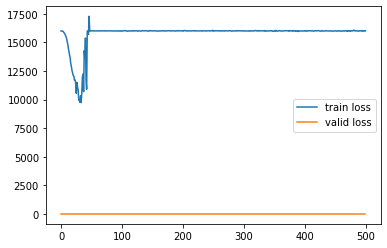

In [10]:
train_loss, valid_loss = train(model_test, 2, 1, epochs=500, lr=1e-3)

In [4]:
dataset = YouCookII(8, "/h/sagar/ece496-capstone/datasets/ycii")
collate = YouCookIICollate(MAX_DETECTIONS=20)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate)

In [5]:
_, boxes, features, steps_list, entity_list, entity_count_list, _, _ = next(iter(dataloader))

In [9]:
steps_list_ = ['add [unused2] garram masala seeds and a bay leaf to [unused2] the oil. [unused3] add [unused2] the lamb to [unused2] the pot. [unused3] [unused3]']
entity_list_ = [[entity_list[0][0], entity_list[0][1]]]
entity_count_list_ = [[entity_count_list[0][0], entity_count_list[0][1]]]
features_ = features[0][0:200][:].unsqueeze(0)
bboxes_ = boxes[0][0:200][:].unsqueeze(0)

In [ ]:
from eval_fi import eval_all_dataset
eval_all_dataset(model_test)

In [ ]:
torch.save(model_test.state_dict(), "/h/sagar/ece496-capstone/weights/weights-nv-8")

In [ ]:
model_test.load_state_dict(torch.load("/h/sagar/ece496-capstone/weights/weights-nv-8"))

In [12]:
E, V, outputs, inputs, VG_ind = model_test(1, 2 + 1, steps_list_, features_, bboxes_, entity_count_list_, entity_list_)

In [ ]:
VG_ind

In [ ]:
E[0][0]

In [ ]:
E[0][1]

In [18]:
correct = 0
incorrect = 0

model_test.eval()
    
for i in range(2):    
    for ent_1 in E[i][0]:
        aligned = (ent_1 * V[i][0:100]).sum(dim=-1)
        aligned = aligned.argmax()

        unaligned = (ent_1 * V[i][100:]).sum(dim=-1)
        unaligned = unaligned.argmax()

        print("Aligned: {}, Unaligned: {}".format(aligned, unaligned))

        if (aligned > unaligned):
            correct+=1
        else:
            incorrect+=1

#     for ent_2 in E[i][1]:
#         aligned = (ent_2 * V[i][100:]).sum(dim=-1)
#         aligned = aligned.argmax()

#         unaligned = (ent_2 * V[i][0:100]).sum(dim=-1)
#         unaligned = unaligned.argmax()

#         print("Aligned: {}, Unaligned: {}".format(aligned, unaligned))

#         if (aligned > unaligned):
#             correct+=1
#         else:
#             incorrect+=1
            
print("Accuracy: {}".format(correct / (correct + incorrect)))

Aligned: 7, Unaligned: 59
Aligned: 2, Unaligned: 59
Aligned: 8, Unaligned: 2
Aligned: 8, Unaligned: 7
Accuracy: 0.5


In [ ]:
E[0]

## After Training 

In [ ]:
E, V, outputs, inputs = model_test(1, 8 + 1, steps_list, features, boxes, entity_count_list, entity_list)

In [ ]:
tokens = model_test.lxmert_tokenizer.convert_ids_to_tokens(inputs.input_ids[0])

In [ ]:
correct = 0
incorrect = 0

for data in dataloader:
    _, boxes, features, steps_list, entity_list, entity_count_list, _, _ = data
    E, V, _, _ = model_test(1, 8 + 1, steps_list, features, boxes, entity_count_list, entity_list)
    
    for i in range(8):    
        for ent_1 in E[i][0]:
            aligned = (ent_1 * V[i][0:100]).sum(dim=-1)
            aligned = aligned.argmax()

            unaligned = (ent_1 * V[i][100:]).sum(dim=-1)
            unaligned = unaligned.argmax()

            #print("Aligned: {}, Unaligned: {}".format(aligned, unaligned))

            if (aligned > unaligned):
                correct+=1
            else:
                incorrect+=1

        for ent_2 in E[i][1]:
            aligned = (ent_2 * V[i][100:]).sum(dim=-1)
            aligned = aligned.argmax()

            unaligned = (ent_2 * V[i][0:100]).sum(dim=-1)
            unaligned = unaligned.argmax()

            #print("Aligned: {}, Unaligned: {}".format(aligned, unaligned))

            if (aligned > unaligned):
                correct+=1
            else:
                incorrect+=1
            
print("Accuracy: {}".format(correct / (correct + incorrect)))

In [ ]:
tokens_1 = tokens
tokens_2 = ["C{}".format(i + 1) for i in range(200)]

In [ ]:
action = 6

attention_1 = [attn[action].unsqueeze(0) for attn in outputs.language_attentions]
attention_2 = [attn[action].unsqueeze(0) for attn in outputs.vision_attentions]

cross = [attn[action].unsqueeze(0) for attn in outputs.cross_encoder_attentions]

In [ ]:
torch.stack(cross).min()

In [ ]:
torch.stack(cross).max()

In [ ]:
from bertviz import model_view
from bertviz import head_view

head_view(
    encoder_attention=attention_2,
    decoder_attention=attention_1,
    cross_attention=cross,
    encoder_tokens=tokens_2,
    decoder_tokens=tokens_1,
    layer=0,
    heads=[4]
)

In [ ]:
len(inputs.input_ids)

In [ ]:
tokens = model_test.lxmert_tokenizer.convert_ids_to_tokens(inputs.input_ids[1])

In [ ]:
entity_list

In [ ]:
entity_list

In [ ]:
tokens

In [ ]:
tokens = model_test.lxmert_tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
tokens_1 = tokens
tokens_2 = ["C{}".format(i + 1) for i in range(200)]
action = 0

attention_1 = [attn[action].unsqueeze(0) for attn in outputs.language_attentions]
attention_2 = [attn[action].unsqueeze(0) for attn in outputs.vision_attentions]

cross = [attn[action].unsqueeze(0) for attn in outputs.cross_encoder_attentions]

In [ ]:
cross[4][0][0][0]

In [ ]:
outputs['vision_output']

In [ ]:
get_loss(E, VG_V)

In [ ]:
VG_V

In [ ]:
len(E)

In [ ]:
len(E[0])

In [ ]:
entity_idx = get_ent_inds(model, entity_list_pairs, steps_pairs)
entity_embeddings = get_entity_embeddings(outputs['language_output'], entity_idx).split(entity_count)

action_idx = (inputs.input_ids == ACTION_TOKEN)
A = outputs['language_output'][action_idx]

V = outputs['vision_output']

In [ ]:
V.size()

In [ ]:
VG_V #PROBABLY THE BBOX EMBEDDINGS FOR "MOST ALIGNED" BBOXES

In [ ]:
loss_pair(E[0], VG_V[0])

In [ ]:
get_loss(E, VG_V)

In [ ]:
count=0
for entity, box in zip(E, VG_V):
    print(count)
    print(loss_pair(entity,box))
    count+=1

In [ ]:
a1_ents = E[1]
#should be of shape 2 x num_ents x 768
#here (in action step 1) the entity list_pairs is ['the lamb', 'the pot'], ['garlic ginger paste'] (so 2 ents, then 1)

In [ ]:
a1_ents[1]

In [ ]:
loss_pair(E[1], VG_V[1])

In [ ]:
S_lm(1,0, E[1], VG_V[1])

In [ ]:
E[1]

In [ ]:
VG_V[1]

In [ ]:
len(E[1])

In [ ]:
len(E[0])

In [ ]:
E[1][0]

In [ ]:
boxes = torch.stack(VG_V[1][0])

In [ ]:
(E[1][0][0]*boxes).sum(dim=-1)

In [ ]:
len(VG_V[1][1][0])

In [ ]:
get_loss(E,V)

In [ ]:
i=0
for ent, b in zip(E,V):
    print(i)
    i+=1

In [ ]:
def get_loss(E, V):
    loss = 0

    for entity, box in zip(E, V):
        loss = loss + loss_pair(entity, box)
        
    print(int(loss))
        
    return loss

#E and V are of shape 2 x num-entities x 768
def loss_pair(E, V):
    delta = torch.full((1, 1), 1000.0).to(device)
    
    loss = 0

    #assert(len(V) == len(E))

    num_actions = len(E)
    
    zero = torch.zeros((1)).to(device)

    for l in range(num_actions):
        for m in range(num_actions):
            before_delta = S_lm(l, m, E, V) - S_lm(l, l, E, V)
            loss = loss + torch.max(zero, (before_delta + delta))[0]

        for m in range(num_actions):
            before_delta = S_lm(m, l, E, V) - S_lm(l, l, E, V)
            loss = loss + torch.max(zero, (before_delta + delta))[0]
            
    #print("Loss: {}".format(loss))
            
    return loss

#INPUTS are ENTITIES and V for each action step
def S_lm(l, m, E, V):
    #print("Computing S_{}{}".format(l, m))
    
    entities = E[m]
    scores = 0
    
    boxes_l_pair = torch.stack([V[:100, :], V[100:,:]])
    
    #pick pair 1 or 0 from l specified
    boxes_l = boxes_l_pair[l]
    #if (len(VG_V[l]) == 0):
    #    return 0
    
    #boxes = torch.stack(VG_V[l])
    #print(boxes.size())
    for j, ent in enumerate(entities):
        #boxes_l should be 100 x 768
            #print(boxes_l.size())
            #broadcasting to get dot prouct with all bboxes in step l (pair part)
            #l = 0 or 1
            max_score = (ent*boxes_l).sum(dim=-1).max()
            scores += max_score
            #scores = scores + (ent * boxes_l).sum(dim=-1).max()
        
    return scores

In [ ]:
i = 1
S_lm(1,1, E[i], V[i])

In [ ]:
S_lm(0,0, E[1], VG_V[1])

In [ ]:
boxes_l = torch.stack([V[0][:100, :], V[0][100:, :]])

In [ ]:
boxes_l.size()